In [1]:
import torch
from transformers import AlignProcessor, AlignModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ruamel_yaml as yaml
import random
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from src.datasets.meme_text_dataloader import get_meme_text_dataloader
from src.utilities import *
from src.models.align_base import align_base

from src.models.albef import ALBEF
from src.models.vit import interpolate_pos_embed
from src.models.tokenization_bert import BertTokenizer

from src.utilities import create_dataset, create_loader
from src.evaluation import evaluation, itm_eval


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else  'cpu')
# Load images into a Dataset, but the pixels will be transformed into list elements, which is not efficient.
meme_loader = get_meme_text_dataloader('memecap', (-1, -1))
# meme_loader.load_datasets(0, 10)
# print(meme_loader.dataset)
# print('meme shape:', np.array(meme_loader.dataset['test']['image'][0]).shape)
# visualize_meme(meme_loader.dataset['test']['image'][0], meme_loader.dataset['test']['caption'][0])
# # TODO (maybe?): Verify if the loading process works well, and if every meme gets resized and cropped correctly.

# load memes and texts
meme_loader.load_datasets(splits=['test']) # test or trainval

Split: test. Length: 559 
Finished loading memes


In [3]:
align_model = align_base()

test_dataset = meme_loader.dataset['test']
# Preprocessing: resize and crop
inputs = align_model.processor(text=test_dataset['caption'], 
                               images=test_dataset['image'], 
                               return_tensors="pt")

In [4]:
from src.evaluation import similarity_align
from src.utilities import recall_at_k
# Calculate the similarity matrix of memes and texts.
text2image_si = similarity_align(inputs, align_model.model, device)
recall_at_k(text2image_si), recall_at_k(text2image_si.T)

torch.Size([559, 640])
torch.Size([559, 640])


({'t2i_r1': 0.5402504472271914,
  't2i_r5': 0.7262969588550984,
  't2i_r10': 0.774597495527728,
  't2i_r_mean': 0.6803816338700059},
 {'t2i_r1': 0.5688729874776386,
  't2i_r5': 0.7423971377459749,
  't2i_r10': 0.7889087656529516,
  't2i_r_mean': 0.7000596302921883})

In [5]:
text2image_si = text2image_si.softmax(dim=1).numpy()
diagonal = np.diagonal(text2image_si)
diagonal[:3], text2image_si[:3, :3]

(array([0.9565187 , 0.48458537, 0.9768763 ], dtype=float32),
 array([[9.5651871e-01, 2.4115345e-05, 6.6250577e-06],
        [5.6351466e-05, 4.8458537e-01, 6.8551250e-05],
        [3.0173535e-07, 6.8626696e-07, 9.7687632e-01]], dtype=float32))

Text(0.5, 0, 'Sorted indexes')

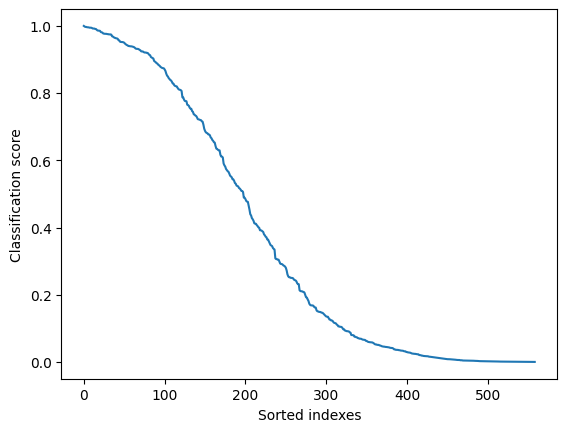

In [17]:
plt.plot(np.sort(diagonal)[::-1])
plt.ylabel('Classification score')
plt.xlabel('Sorted indexes')

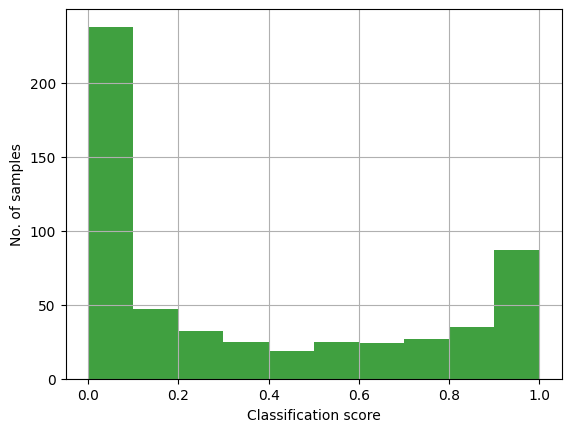

In [16]:
n, bins, patches = plt.hist(diagonal, 10, facecolor='g', alpha=0.75)
plt.xlabel('Classification score') 
plt.ylabel('No. of samples') 
plt.grid(True) 

In [8]:
import pprint
sorted_idx = np.argsort(diagonal)[::-1]
def show_case(idx):
    print('Contractive similarity:', text2image_si[sorted_idx[idx], sorted_idx[idx]])
    pprint.pprint(meme_loader.test_text_data[sorted_idx[idx]])
    plt.imshow(test_dataset['image'][sorted_idx[idx]])
    plt.title(test_dataset['caption'][sorted_idx[idx]])
    plt.show()

# True positive samples

Contractive similarity: 0.99996245
{'category': 'memes',
 'img_captions': ['Pam is looking at four different pictures of the same red '
                  'apple.'],
 'img_fname': 'memes_ypraz9.png',
 'meme_captions': ['Eye doctors expect you to see the difference between '
                   'identical pictures of the apple.',
                   'The meme poster mocks the stupid test.'],
 'metaphors': [{'meaning': 'Meme poster', 'metaphor': 'Pam'},
               {'meaning': 'Meme poster',
                'metaphor': 'four different pictures'},
               {'meaning': 'Meme poster', 'metaphor': 'the same red apple'},
               {'meaning': 'Meme poster', 'metaphor': 'looking'}],
 'post_id': 'ypraz9',
 'title': "They're the same.",
 'url': 'https://i.redd.it/x5t5927lpsy91.png'}


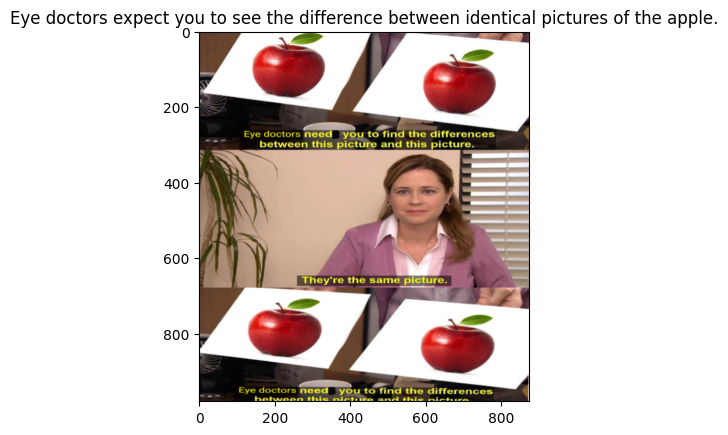

In [19]:
for i in range(1):
    show_case(i)

# False negative samples

Contractive similarity: 8.02649e-07
{'category': 'memes',
 'img_captions': ['A girl is holding up a toy.'],
 'img_fname': 'memes_z0gtdq.png',
 'meme_captions': ["Meme poster doesn't like how the new Pokemon look.",
                   "Meme poster doesn't like the new pokemon games.",
                   'The meme poster feels disgusting about its appearance.'],
 'metaphors': [{'meaning': 'Meme poster', 'metaphor': 'A girl'},
               {'meaning': 'Pokemon', 'metaphor': 'a toy'}],
 'post_id': 'z0gtdq',
 'title': 'Fixed a meme from u/InBetweenSeen',
 'url': 'https://i.redd.it/0ljpisd9081a1.jpg'}


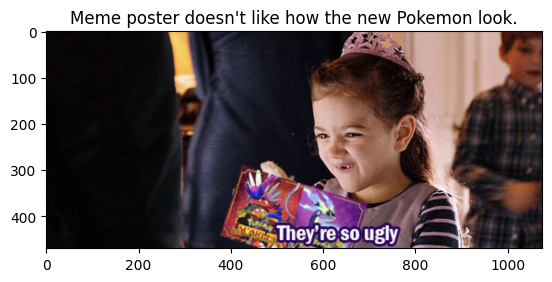

In [20]:
for i in range(-1, -2, -1):
    show_case(i)

# False positive samples

Best match score: 0.19379814
{'category': 'memes',
 'img_captions': ['A girl is holding up a toy.'],
 'img_fname': 'memes_z0gtdq.png',
 'meme_captions': ["Meme poster doesn't like how the new Pokemon look.",
                   "Meme poster doesn't like the new pokemon games.",
                   'The meme poster feels disgusting about its appearance.'],
 'metaphors': [{'meaning': 'Meme poster', 'metaphor': 'A girl'},
               {'meaning': 'Pokemon', 'metaphor': 'a toy'}],
 'post_id': 'z0gtdq',
 'title': 'Fixed a meme from u/InBetweenSeen',
 'url': 'https://i.redd.it/0ljpisd9081a1.jpg'}


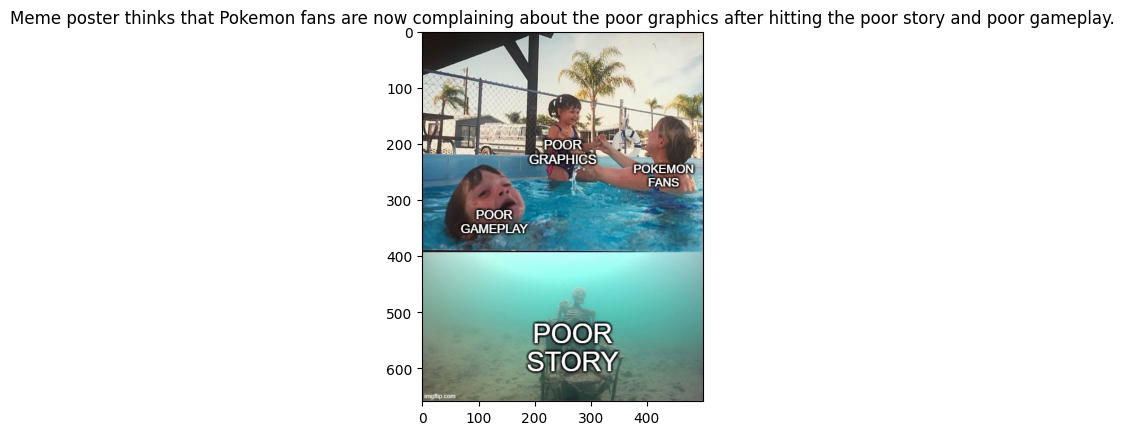

{'category': 'memes',
 'img_captions': ['A mom is playing with her daughter next to a boy drowning '
                  'who eventually becomes a skeleton.'],
 'img_fname': 'memes_yzu2rh.png',
 'meme_captions': ['Meme poster thinks that Pokemon fans are now complaining '
                   'about the poor graphics after hitting the poor story and '
                   'poor gameplay.',
                   'Meme poster is trying to convey that Pokemon fans are now '
                   'complaining about poor graphics when there has been poor '
                   'gameplay and poor story all along.',
                   "The meme poster says that though Pokemon's Gameplay and "
                   "story aren't good, people likes Pokemon.",
                   'Meme poster is trying to convey that Pokemon fans who are '
                   'playing the newer games are criticizing the graphics when '
                   'they should be criticizing other stuff like gameplay and '
                 

In [21]:
# text2image_si = text2image_si.softmax(dim=1).numpy()
# diagonal = np.diagonal(text2image_si)
def find_false_positives(idx):
    best_match_idx = np.argmax(text2image_si[sorted_idx[idx], :])
    print('Best match score:', text2image_si[sorted_idx[idx], best_match_idx])
    pprint.pprint(meme_loader.test_text_data[sorted_idx[idx]])
    plt.imshow(test_dataset['image'][best_match_idx])
    plt.title(test_dataset['caption'][best_match_idx])
    plt.show()
    pprint.pprint(meme_loader.test_text_data[best_match_idx])
    
for i in range(-1, -2, -1):
    find_false_positives(i)